Instructions: Run all of the cells in this notebook from the "Setup" and "Load Precomputed Data" sections. Then, find your name in the "Model Playground" section and play around with it. Read the documentation about the model you are using, and if you feel ambitious, try to find other examples in the literature. Take some time to understand all of the parameters available to your model and try to quantify the effects of each. For example, some parameters affect the speed of computation while others should be set only under certain circumstances. Others will tune the model on the bias-variance scale trading off accuracy for genericity. Feel free to take notes under your section and commit them back to the repo. This should be considered a living document that we all can gain insight from.

As a bare minimum see if you can answer the following questions regarding your assigned model:

* Give a brief description of how your model works.
* What are the hyperparameters for your model?
* How did you tune them, and what worked best?
* How many relevant dimensions were needed to compute your data?
* What were the most relevant predictors?

# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import ensemble, svm, model_selection, neighbors, linear_model, gaussian_process, neural_network, naive_bayes, tree
from read_msc import *
import time
import pickle

/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Pretty Colors

In [2]:
light_red = '#fbb4ae'
red = '#e41a1c'

light_blue = '#b3cde3'
blue = '#377eb8'

light_green = '#ccebc5'
green = '#4daf4a'

light_purple = '#decbe4'
purple = '#984ea3'

light_orange = '#fed9a6'
orange = '#ff7f00'

light_palette = [light_red, light_blue, light_green, light_purple, light_orange]
bold_palette = [red, blue, green, purple, orange]

## Reusable Variables and Functions

In [3]:
def show_image(image):
    plt.figure(num=None, dpi=200)
    plt.imshow(image, cmap=plt.cm.Greys_r)
    plt.axis('off')

def show_training_samples(image, in_samples, out_samples):
    show_image(image)
    plt.scatter(in_samples[:, 0], in_samples[:, 1], color=orange, s=1, marker=',')
    plt.scatter(out_samples[:, 0], out_samples[:, 1], color=purple, s=1, marker=',')

def show_classifier_result(compiled_data, classifier):
    flattened_data = compiled_data.reshape(-1, compiled_data.shape[-1])
    predicted_labels = classifier.predict(flattened_data)
    predicted_labels = predicted_labels.reshape(compiled_data.shape[0], compiled_data.shape[1])
    show_image(predicted_labels)

# Load Precomputed Data

## Load Image and Filters

In [4]:
fname_base = 'max_diadem_smoothed'
compiled_data = np.load(fname_base + '_input.npy')

with open(fname_base + '_dimensions.txt', 'r') as f:
    dimensions = [line.strip() for line in f]

## Load Morse-Smale Complex

In [5]:
fname_raw = fname_base + ".raw"
test_msc_coarse = MSC()
test_msc_coarse.read_from_file(fname_raw)

## Load Training Data

In [6]:
in_samples = np.loadtxt(fname_base + '_in_samples.txt', dtype=int)
out_samples = np.loadtxt(fname_base + '_out_samples.txt', dtype=int)

In [7]:
in_class = compiled_data[in_samples[:, 1], in_samples[:, 0], :]
out_class = compiled_data[out_samples[:, 1], out_samples[:, 0], :]
train_x = np.vstack((in_class, out_class))
train_y = np.hstack((np.ones(in_class.shape[0]), np.zeros(out_class.shape[0])))

## Visually Verify Everything Loaded Properly

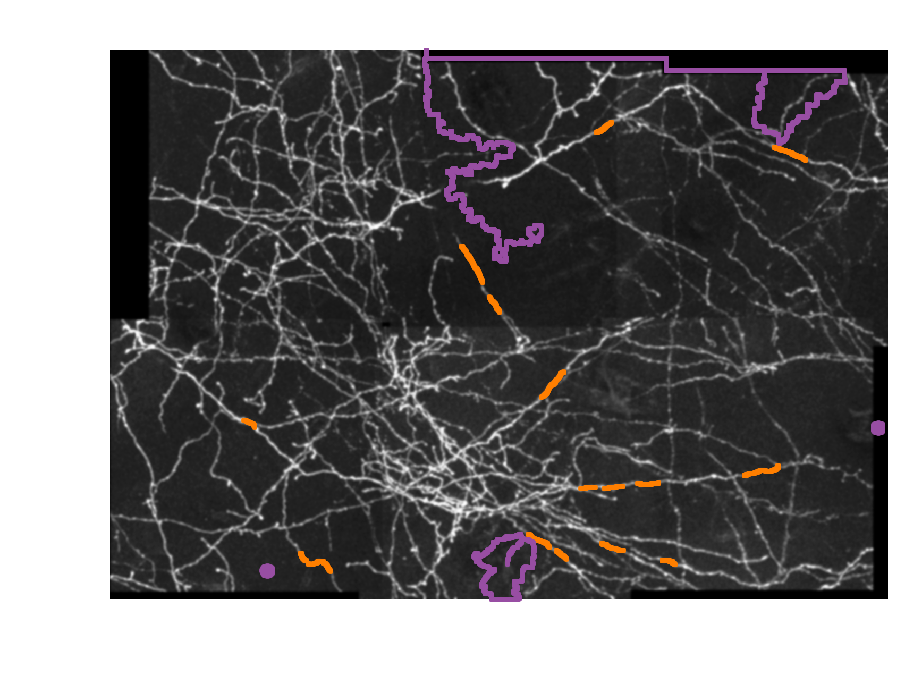

In [8]:
show_training_samples(compiled_data[:,:,0], in_samples, out_samples)

# Model Playground

## Example Analysis

I will start with a generic example using _logistic regression_, if you are lacking creativity/time you could replicate this analysis exactly only swapping out the relevant information of your model.

### Logistic Regression

Aliases:
* Logit regression
* Maximum-entropy classification (MaxEnt)
* Log-linear classifier

We model the probability of a binary outcome (0 or 1) for a given input using a logistic function:

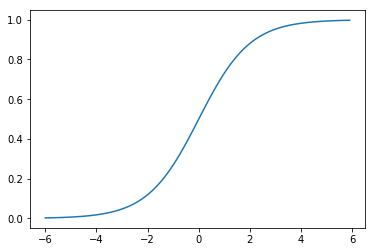

In [9]:
def logistic(x):
    L = 1   # maximum value
    k = 1   # steepness
    x0 = 0  # midpoint
    return L / (1 + np.exp(-k*(x-x0)))

plt.figure()
x = np.arange(-6, 6, 0.1)
plt.plot(x, logistic(x))
plt.show()

#### Optimization Problem:

* _$L_2$_ Penalized Logistic Regression:

$$\min_{w,c}\frac{1}{2}w^Tw + C\sum_{i=1}^{n}\log(e^{-y_i(X_i^Tw + c)} + 1)$$

* _$L_1$_ Penalized Logistic Regression:

$$\min_{w,c}||w||_1 + C\sum_{i=1}^{n}\log(e^{-y_i(X_i^Tw + c)} + 1)$$


#### Parameters

* `penalty` - see above. The $L_1$ penalty can only be used with the following parameters:
  * dual=False
  * solver={'liblinear', 'saga'}
* `dual` - set to False when you have more samples than dimensions (arguably the typical case for us)
* `C` - penalty factor. Shifts answer on bias-variance trade-off scale. Larger values favor ovefitting a model whil smaller favor 
* `fit_intercept` - An extra parameter than needs fitted.
* `intercept_scaling` - TODO
* `solver` - There are a bunch of different available implementations with their own trade-offs. I explore these in the context of our problem in a later cell.

stopping criteria:
 * `tol`
 * `max_iter`
 
performance:
 * `n_jobs` - Use -1 for best performance, though it won't matter if the solver is liblinear.
 * `warm_start` - shouldn't matter as we are not typically retraining our model, otherwise uses the last fit as the initialization for the next call to fit
 
misc:
 * `random_state` - a few of the solvers utilize random shuffling of the data, this ensures reproducibility
 * `class_weight` - potentially useful if you have a class imbalance problem
 * `verbose` - we can probably keep this off
 * `multi_class` - Don't worry about this one, for now we are focusing only on binary classification.

#### Tuning

{'C': 1.0, 'penalty': 'l2'} 0.9895224356540885


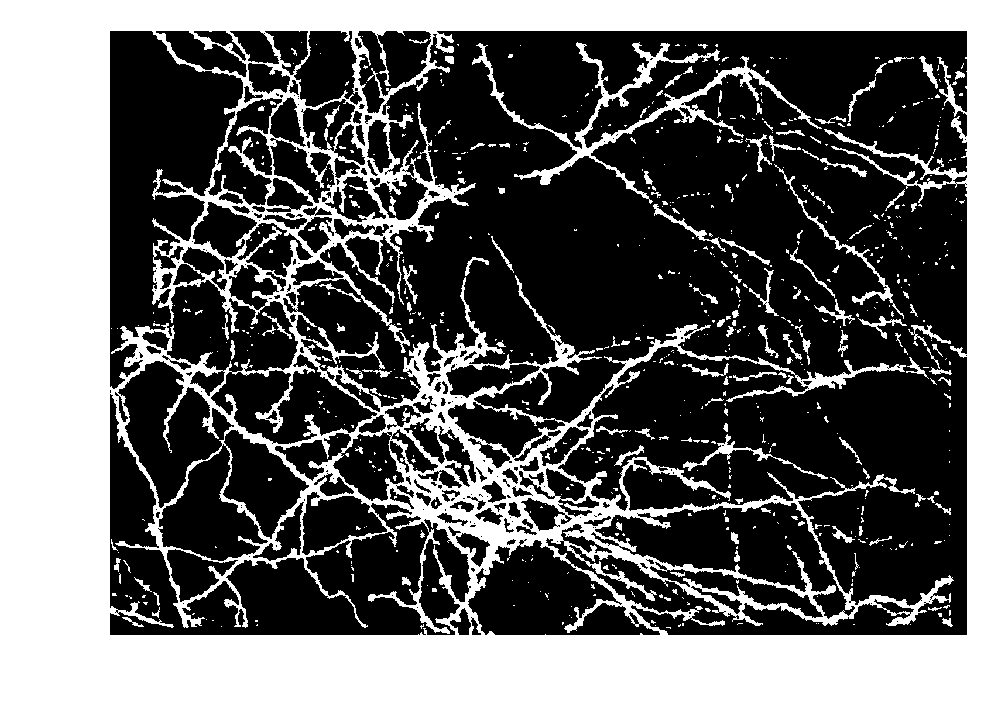

In [10]:
logit = linear_model.LogisticRegression(penalty='l2',
                                        dual=False,
                                        tol=0.0001,
                                        C=1.0,
                                        fit_intercept=True,
                                        intercept_scaling=1,
                                        class_weight=None,
                                        random_state=None,
                                        solver='liblinear',
                                        max_iter=100,
                                        verbose=0,
                                        warm_start=False,
                                        n_jobs=1)
logit.fit(train_x, train_y)
logit.score(train_x, train_y)

param_grid = {'penalty': ['l1', 'l2'],
              'C': [1.0, 10],}

best_logit = model_selection.GridSearchCV(logit, param_grid)
best_logit.fit(train_x, train_y)
print(best_logit.best_params_, best_logit.best_score_)
show_classifier_result(compiled_data, best_logit)

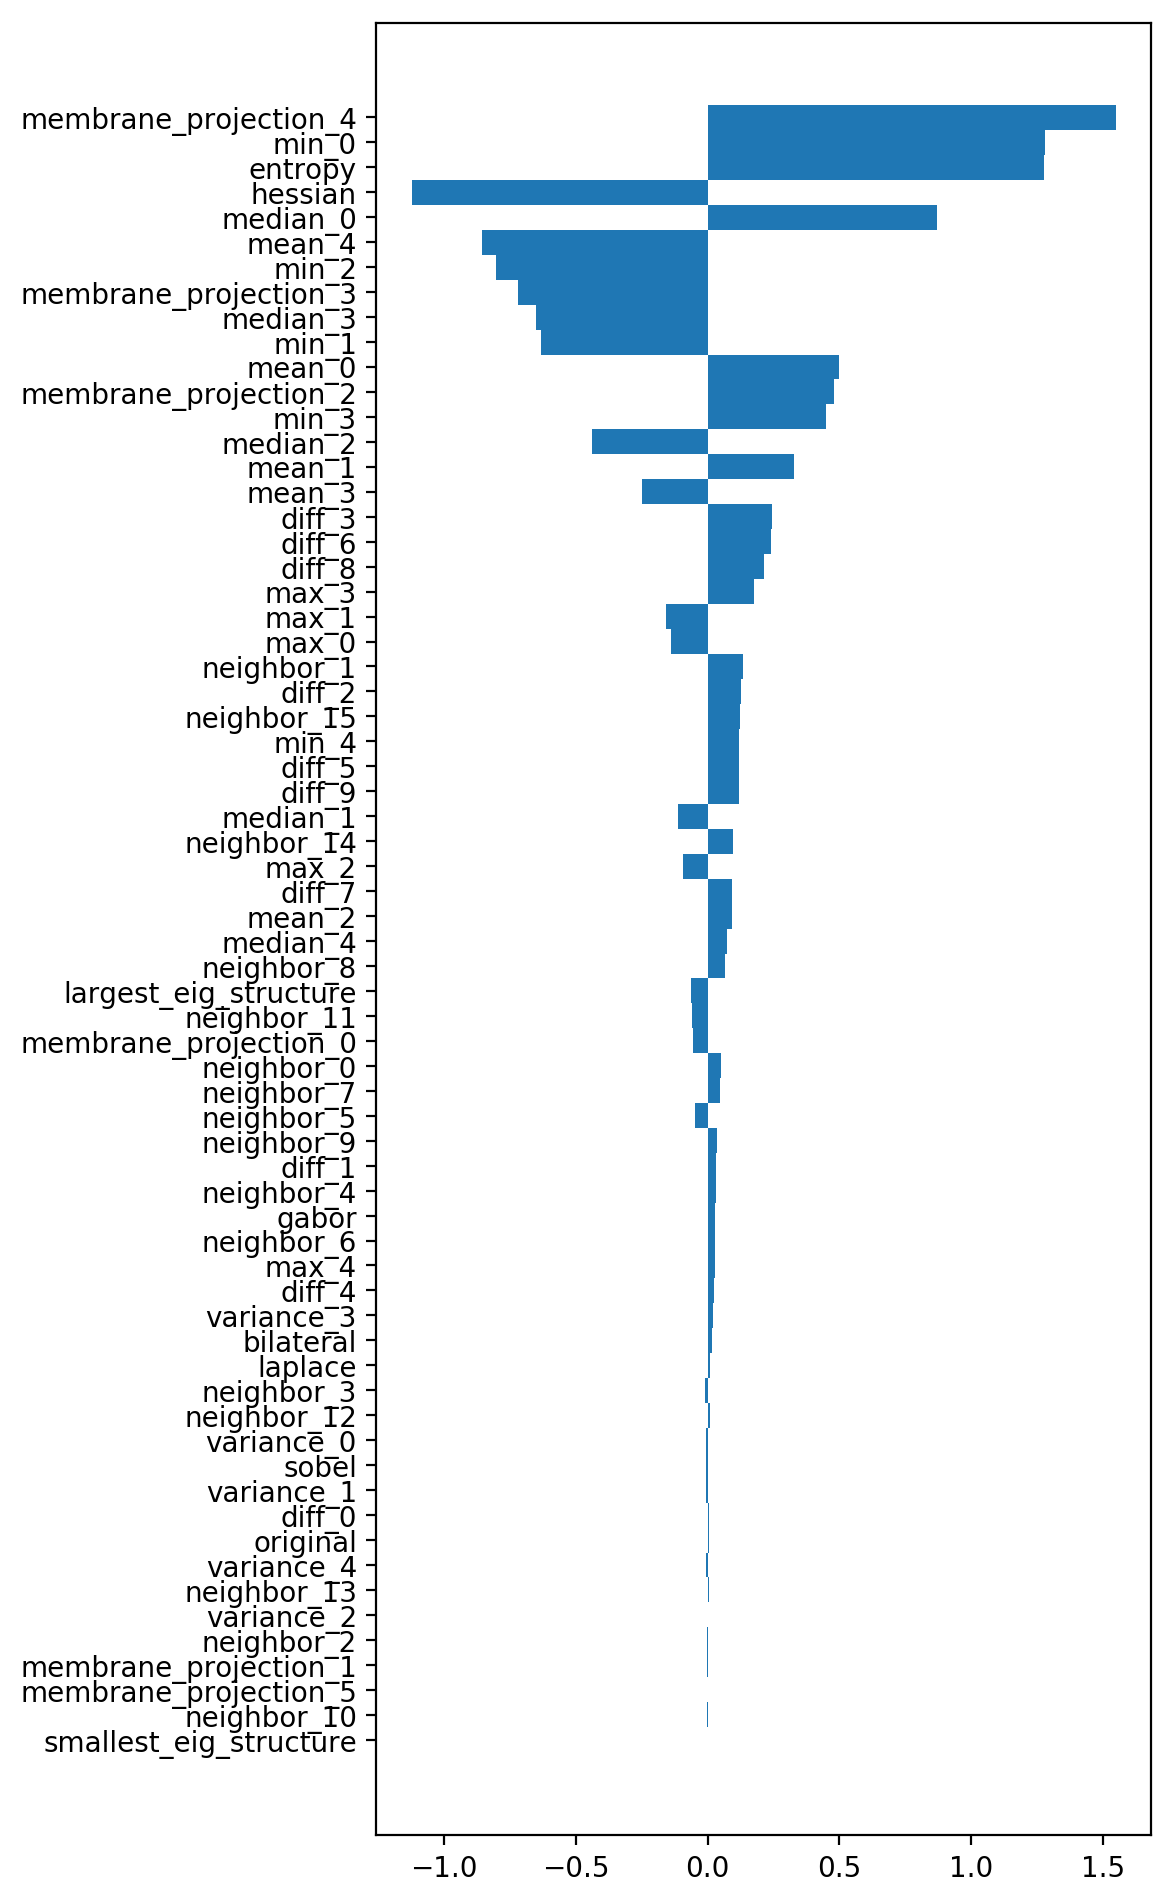

In [11]:
logit = best_logit.best_estimator_
coefs = logit.coef_[0]
sorted_indices = np.argsort(np.abs(coefs))
dimensions = np.array(dimensions)
plt.figure(dpi=200, figsize=(5,12))
_ = plt.barh(y=np.arange(0, 1*len(dimensions), 1), width=coefs[sorted_indices], align='center', height=1.0, tick_label=dimensions[sorted_indices])

Okay, I like this model, let's pickle it for use later.

In [12]:
f = open('logit.pk', 'wb')
pickle.dump(logit, f)
f.close()

Try again with only the top 10 performing filters and also try out the different solvers:

/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1235: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


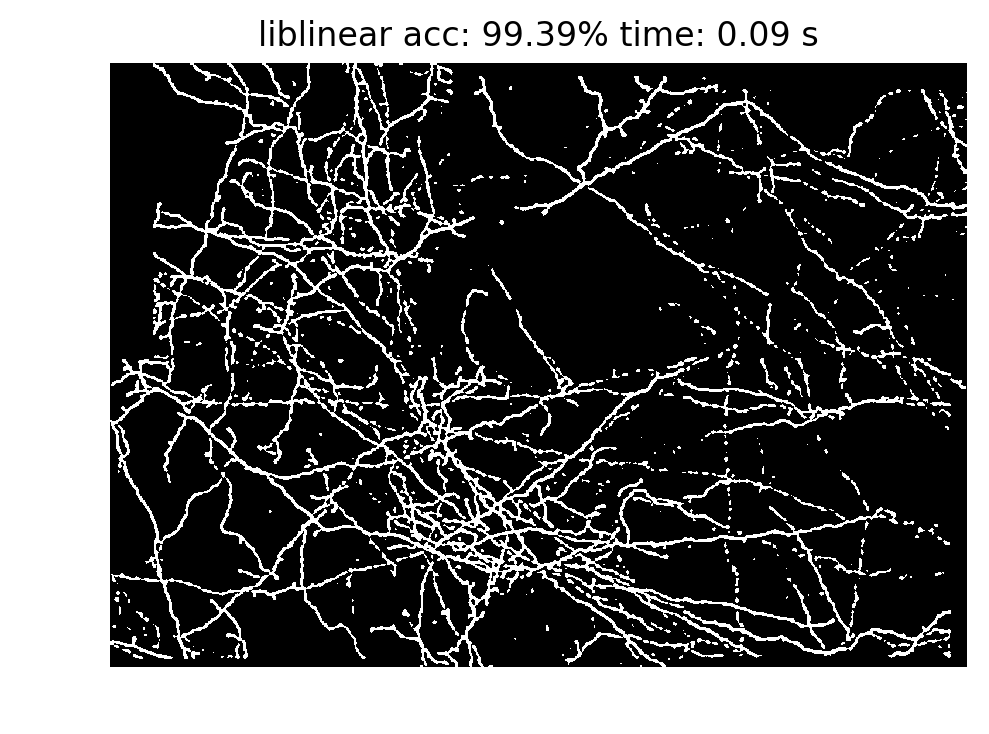

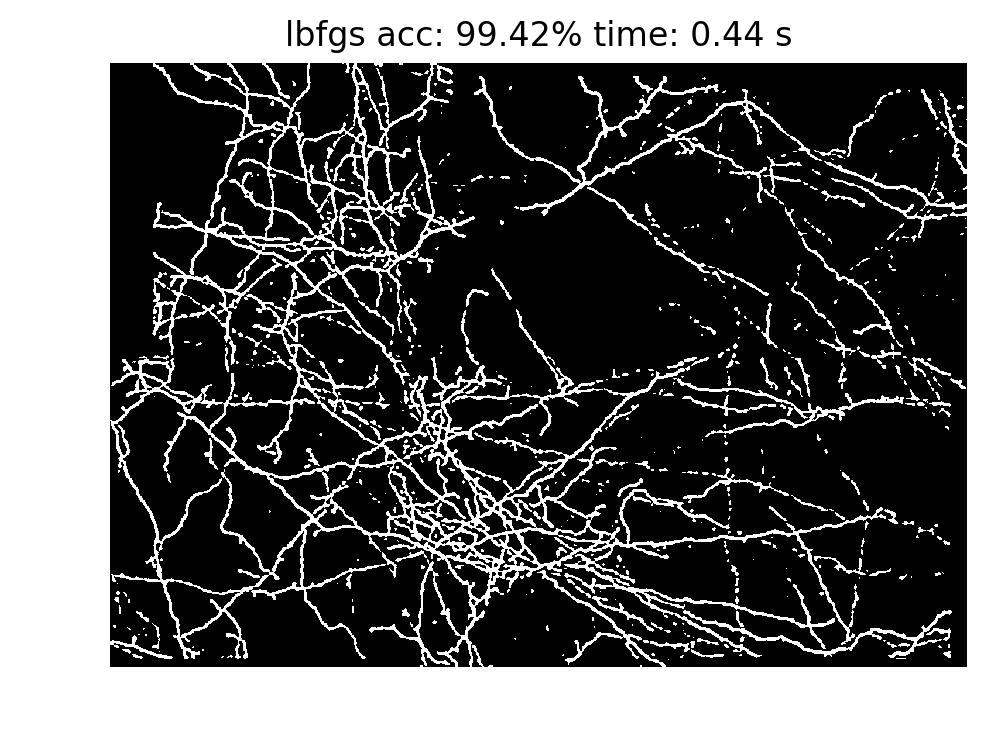

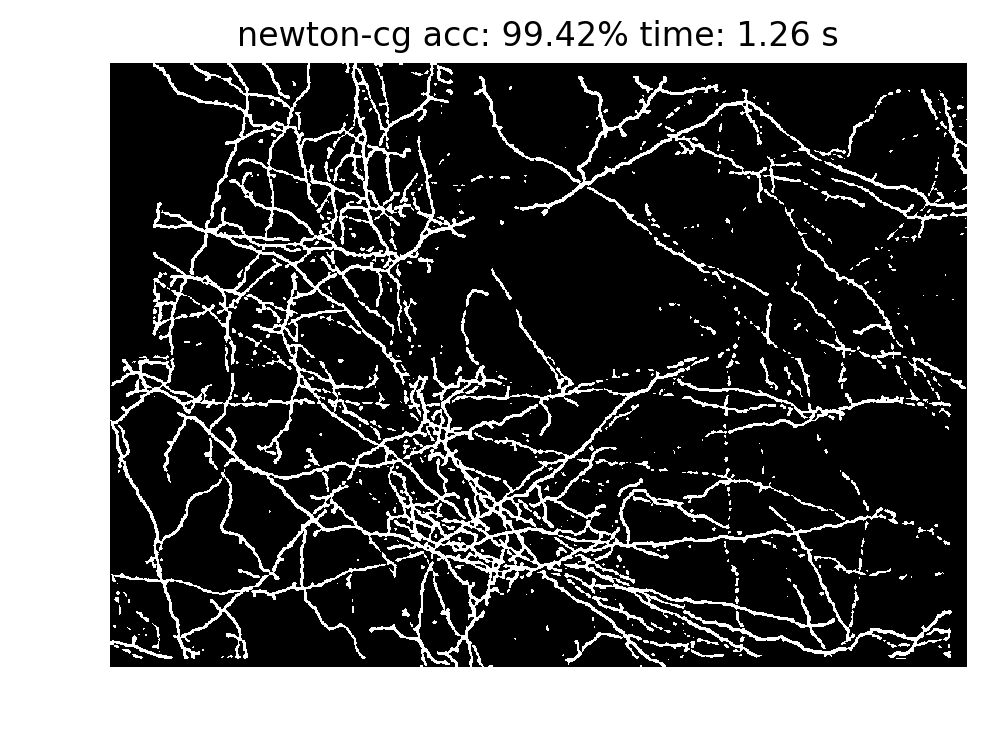

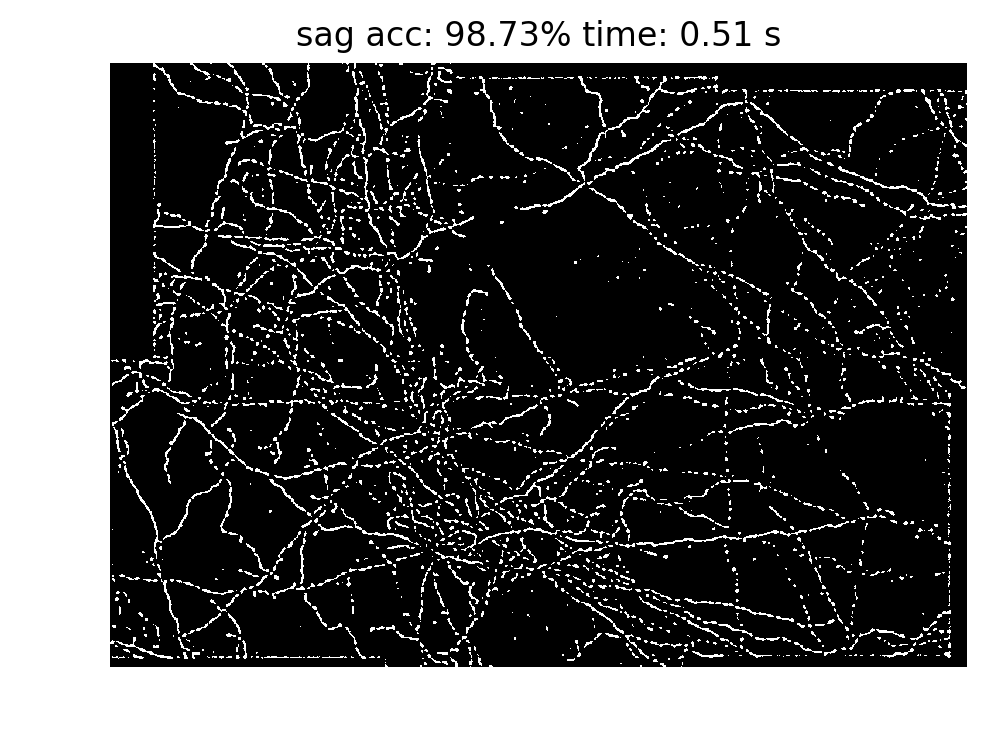

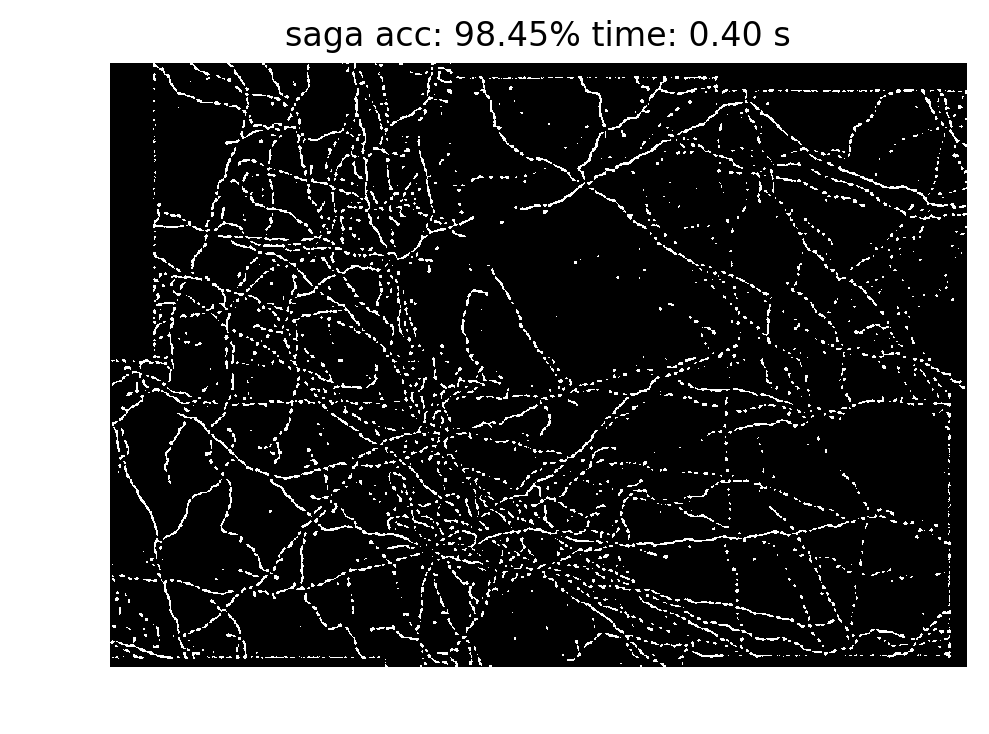

In [13]:
top_filters = sorted_indices[:10]
reduced_train_x = train_x[:, top_filters]

for solver in ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']:
    start = time.time()
    logit_reduced = linear_model.LogisticRegression(penalty='l2',
                                                    tol=0.0001,
                                                    C=1.0,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    solver=solver,
                                                    max_iter=100,
                                                    n_jobs=-1)

    logit_reduced.fit(reduced_train_x, train_y)
    end = time.time()
    acc = logit_reduced.score(reduced_train_x, train_y)
    show_classifier_result(compiled_data[:, :, top_filters], logit_reduced)
    plt.gca().set_title('{} acc: {:.2%} time: {:.2f} s'.format(solver, acc, end-start))

## Cameron (Nearest Neighbor Classifier)

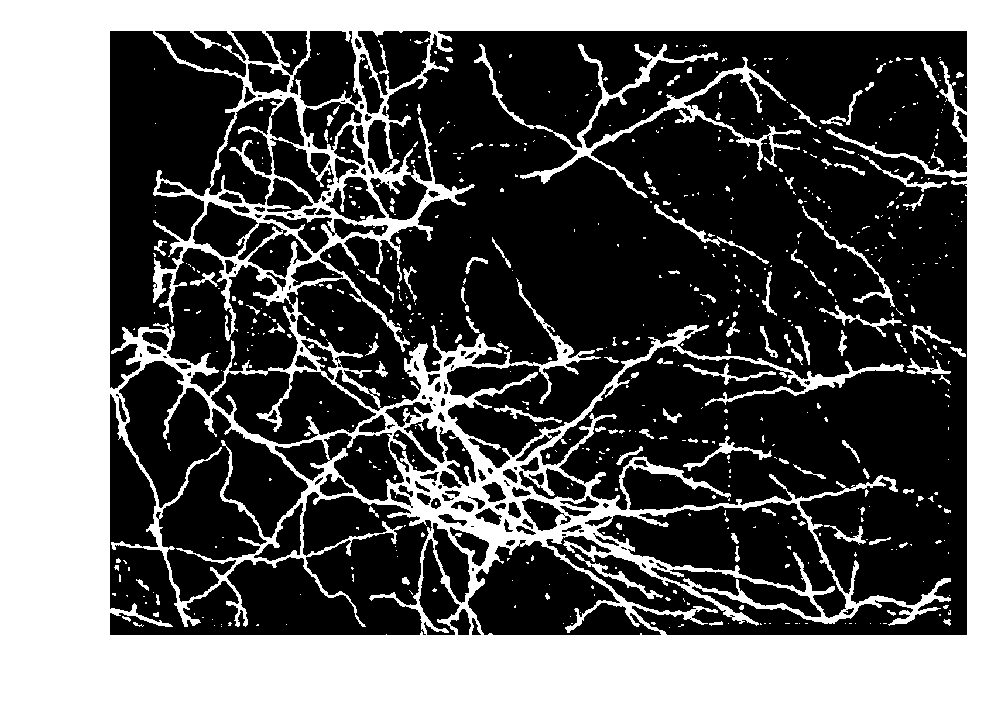

In [14]:
knn = neighbors.KNeighborsClassifier(n_neighbors=25,
                                     weights='uniform', 
                                     algorithm='auto', 
                                     leaf_size=30, 
                                     p=2, 
                                     metric='minkowski', 
                                     metric_params=None, 
                                     n_jobs=1)

knn.fit(train_x, train_y)
knn.score(train_x, train_y)
show_classifier_result(compiled_data, knn)

## Nathan (Radial Basis Function Support Vector Machine)

In [ ]:
svc = svm.SVC(C=1.0,
              kernel='rbf',
              gamma='auto',
              coef0=0.0,
              shrinking=True,
              probability=False,
              tol=0.001,
              cache_size=2048,
              class_weight=None,
              verbose=False,
              max_iter=-1,
              decision_function_shape='ovr',
              random_state=None)
              
svc.fit(train_x, train_y)
svc.score(train_x, train_y)
show_classifier_result(compiled_data, svc)

## Sam & Zhimin (Gaussian Process)

In [ ]:
gp = gaussian_process.GaussianProcessClassifier(kernel=None,
                                                optimizer='fmin_l_bfgs_b',
                                                n_restarts_optimizer=0,
                                                max_iter_predict=100,
                                                warm_start=False,
                                                copy_X_train=True,
                                                random_state=None,
                                                multi_class='one_vs_rest',
                                                n_jobs=None)

gp.fit(train_x, train_y)
gp.score(train_x, train_y)
show_classifier_result(compiled_data, gp)

## Sam & Zhimin (Naive Bayes Classifier)

In [ ]:
bayes = naive_bayes.GaussianNB(priors=None, var_smoothing=1e-09)
# bayes = naive_bayes.MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None)
# bayes = naive_bayes.ComplementNB(alpha=1.0, fit_prior=True, class_prior=None, norm=False)

bayes.fit(train_x, train_y)
bayes.score(train_x, train_y)
show_classifier_result(compiled_data, bayes)

## Torin (Decision Tree)

In [ ]:
%matplotlib inline  

dt = tree.DecisionTreeClassifier(criterion='gini',
                                 splitter='best',
                                 max_depth=None,
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0,
                                 max_features=None,
                                 random_state=None,
                                 max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 class_weight=None,
                                 presort=False)

dt.fit(train_x, train_y)
dt.score(train_x, train_y)


param_grid = {'criterion': ['entropy'],
              'max_depth': [18, 19, 20, 21, 22, 23, 24, 25, None ],
             }

best_dt = model_selection.GridSearchCV(dt, param_grid)
best_dt.fit(train_x, train_y)
print(best_dt.best_params_, best_dt.best_score_)
show_classifier_result(compiled_data, best_dt)
show_classifier_result(compiled_data, dt)


In [ ]:
f = open('dt.pk', 'wb')
pickle.dump(dt, f)
f.close()

In [ ]:
top_filters = sorted_indices[:10]
reduced_train_x = train_x[:, top_filters]

for solver in ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']:
    start = time.time()
    dt_reduced = tree.DecisionTreeClassifier(criterion='entropy',
                                 splitter='best',
                                 max_depth=23,
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0,
                                 max_features=None,
                                 random_state=None,
                                 max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 class_weight=None,
                                 presort=False)
    dt_reduced.fit(reduced_train_x, train_y)
    end = time.time()
    acc = dt_reduced.score(reduced_train_x, train_y)
    show_classifier_result(compiled_data[:, :, top_filters], dt_reduced)
    plt.gca().set_title('{} acc: {:.2%} time: {:.2f} s'.format(solver, acc, end-start))

## Di (Random Forest)

* Main parameters to tune
    * max_features
    * n_estimators
    * min_sample_leaf
* Traing:
    * n_jobs
    * random_state
    * oob_score (similar to Leave-One-Out Cross Validation, LOOCV)

* `n_estimators`, int - The number of trees in the forest.

* `criterion`, string - The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific. 
    * Gini:

$$Gini(E) = 1- C\sum_{j=1}^{c}p_j^2$$
    * Entropy:

$$ H(E) = -C\sum_{j=1}^{c}p_j \log(p_j)$$


* `max_depth`. int or None - The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. 
* `min_samples_split`, int, float, optional - The minimum number of samples required to split an internal node:
    * If int, then consider min_samples_split as the minimum number.
    * If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.
* `min_samples_leaf`, int, float, optional - The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression: 
    * If int, then consider min_samples_leaf as the minimum number.
    * If float, then min_samples_leaf is a fraction and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.
* `min_weight_fraction_leaf`, float - The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.

* `max_features`, int, float, string or None, optional, - The number of features to consider when looking for the best split:
    * If int, then consider max_features features at each split.
    * If float, then max_features is a fraction and int(max_features * n_features) features are considered at each split.
    * If “auto”, then max_features=sqrt(n_features).
    * If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
    * If “log2”, then max_features=log2(n_features).
    * If None, then max_features=n_features.

    * `Note`: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.
* More to Come 

stopping criteria:
 * at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.
 
performance:
 * `n_jobs`int or None - The number of jobs to run in parallel for both fit and predict. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors.
 
 * `warm_start` - shouldn't matter as we are not typically retraining our model, otherwise uses the last fit as the initialization for the next call to fit
 
misc:
 * `random_state`, int - a few of the solvers utilize random shuffling of the data, this ensures reproducibility. 
     * If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.
 * `class_weight` - potentially useful if you have a class imbalance problem
 * `verbose` - we can probably keep this off

/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-package

Score:  0.9984055880343178


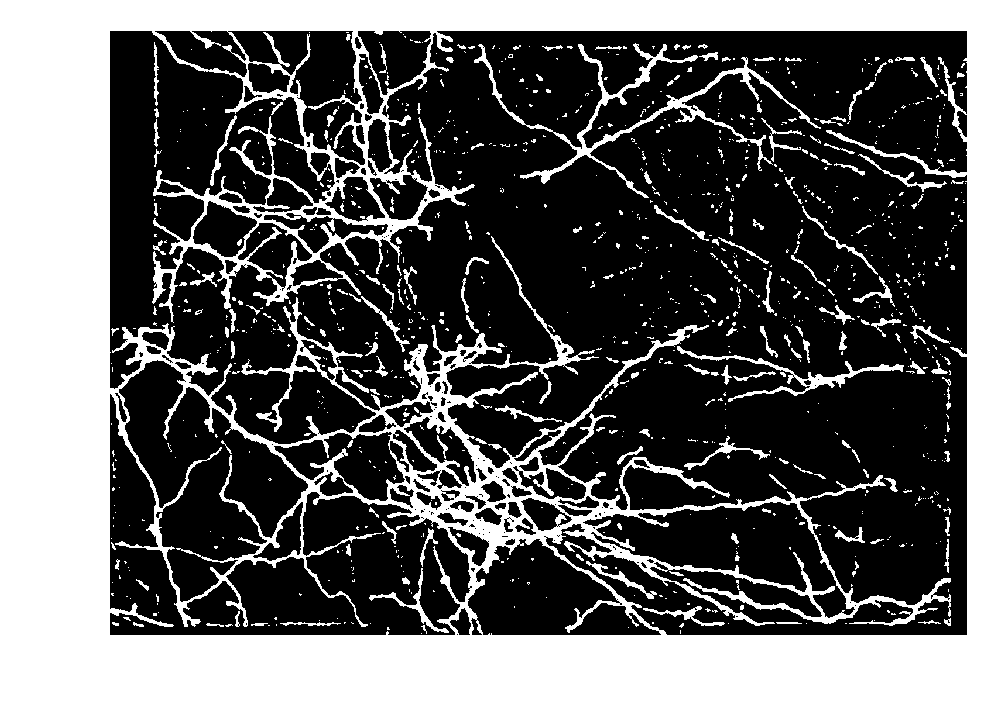

In [9]:
from sklearn.metrics import roc_auc_score
from sklearn import cross_validation, metrics

rf = ensemble.RandomForestClassifier(n_estimators=10,
                                     criterion='gini',
                                     max_depth=None,
                                     min_samples_split=2,
                                     min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0,
                                     max_features='auto',
                                     max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     bootstrap=True,
                                     oob_score=True,
                                     n_jobs=-1,
                                     random_state=None,
                                     verbose=0,
                                     warm_start=False,
                                     class_weight=None)


rf.fit(train_x, train_y)
rf.score(train_x, train_y)
print("Score: ", rf.oob_score_)
#print("Feature Importance: ", rf.feature_importances_)
show_classifier_result(compiled_data, rf)


In [10]:
f = open('rf.pk', 'wb')
pickle.dump(rf, f)
f.close()

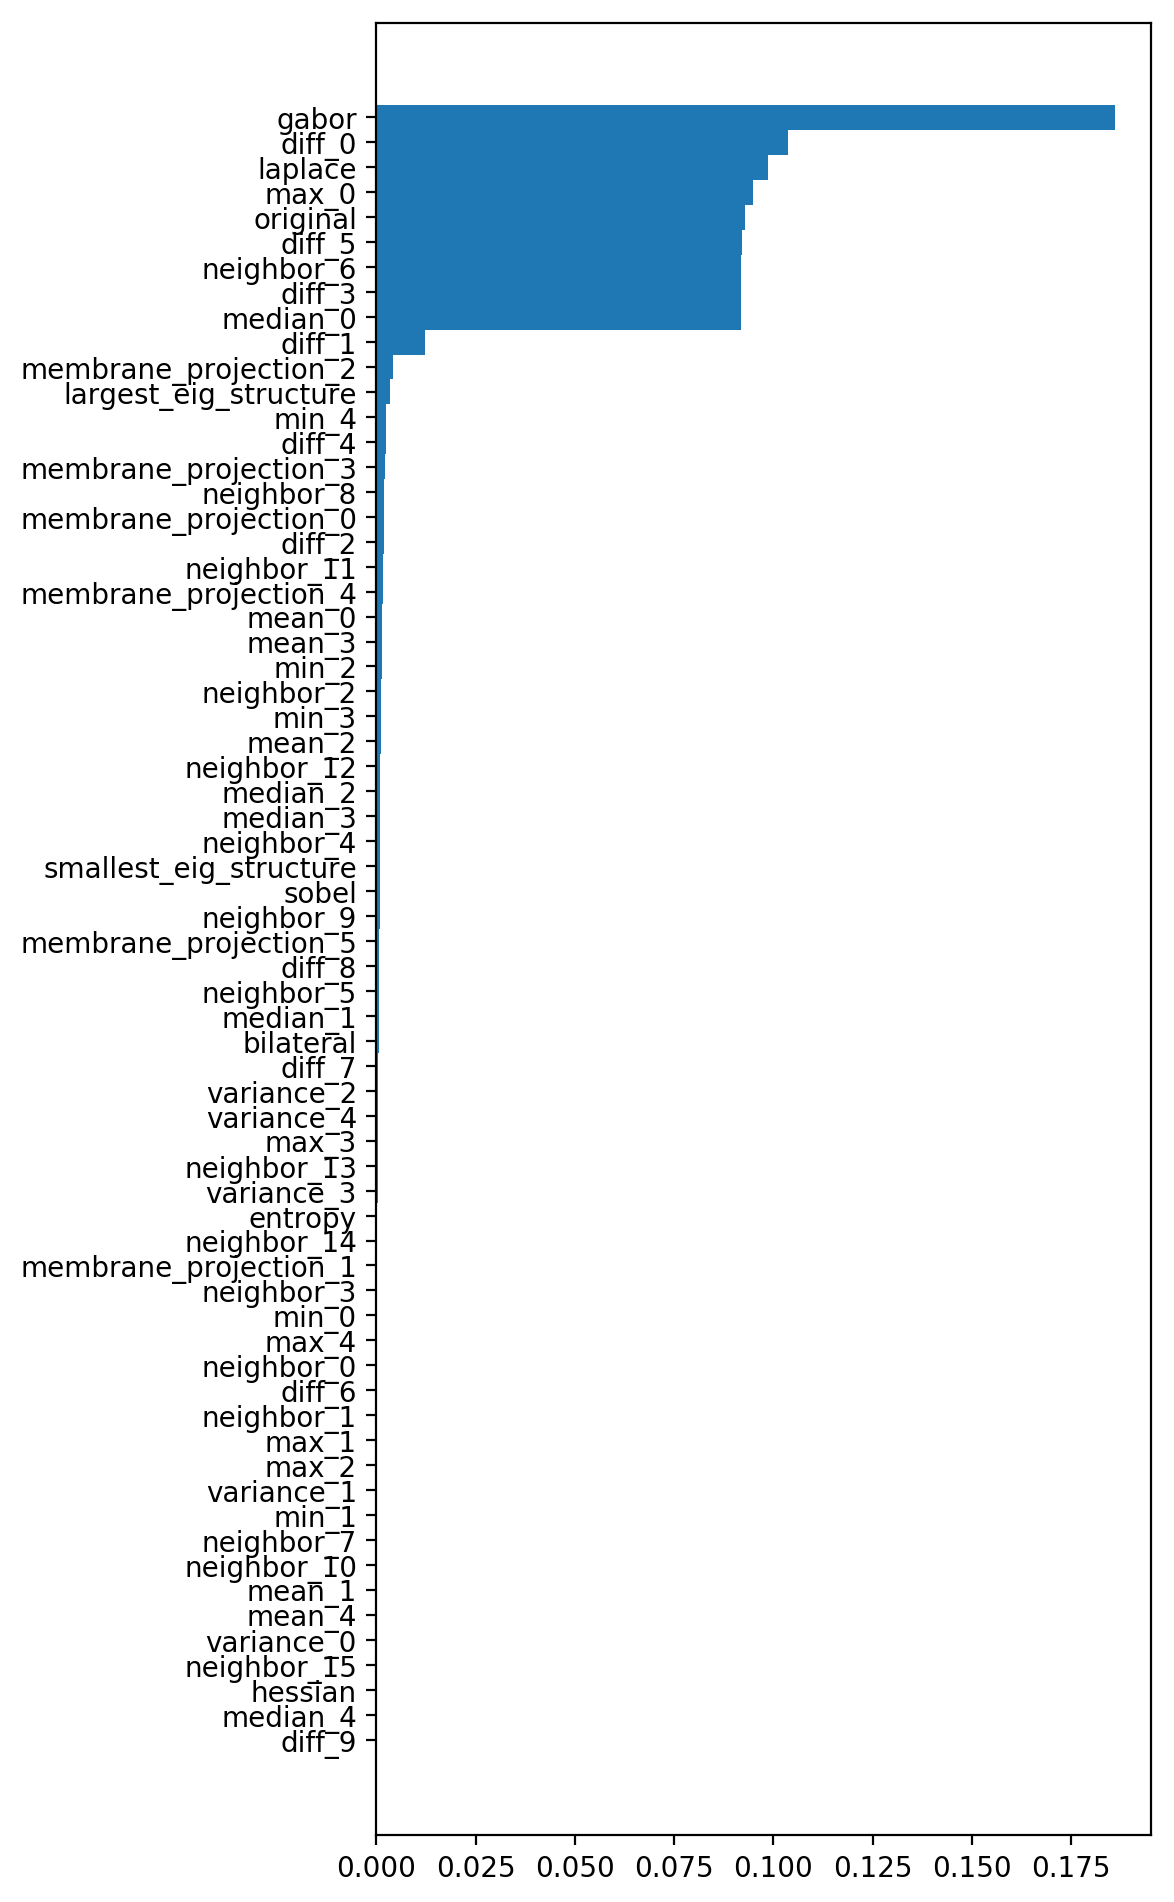

In [11]:
coefs = rf.feature_importances_
sorted_indices = np.argsort(np.abs(coefs))
dimensions = np.array(dimensions)
plt.figure(dpi=200, figsize=(5,12))
_ = plt.barh(y=np.arange(0, 1*len(dimensions), 1), width=coefs[sorted_indices], align='center', height=1.0, tick_label=dimensions[sorted_indices])

/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/media/orpheus92/OS/conda/envs/Ditorch/lib/

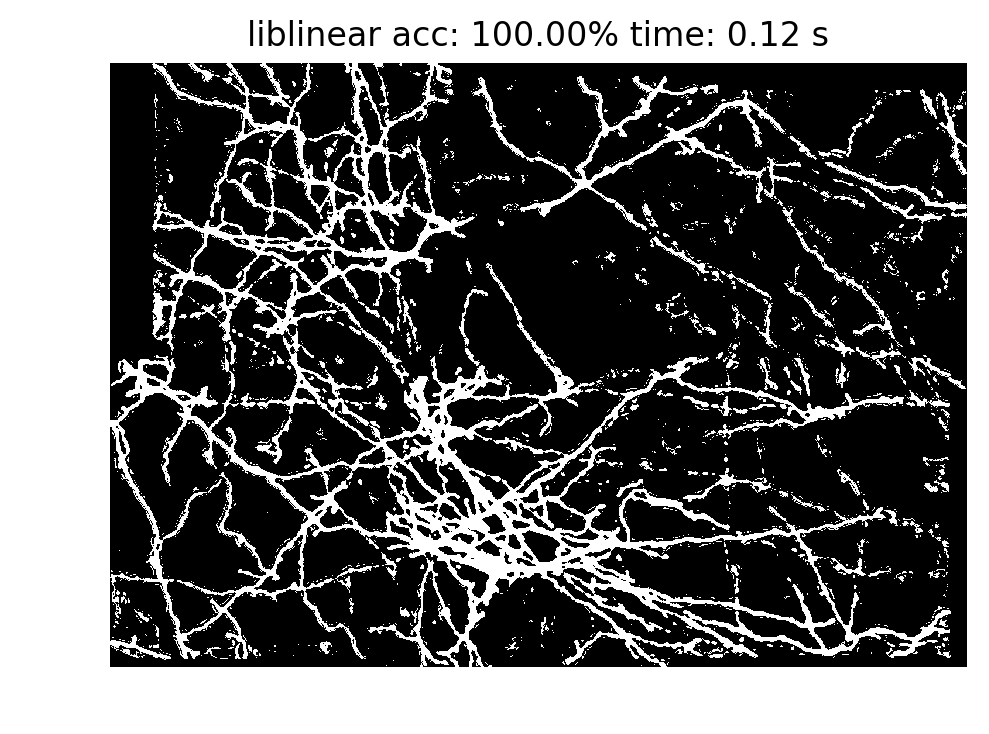

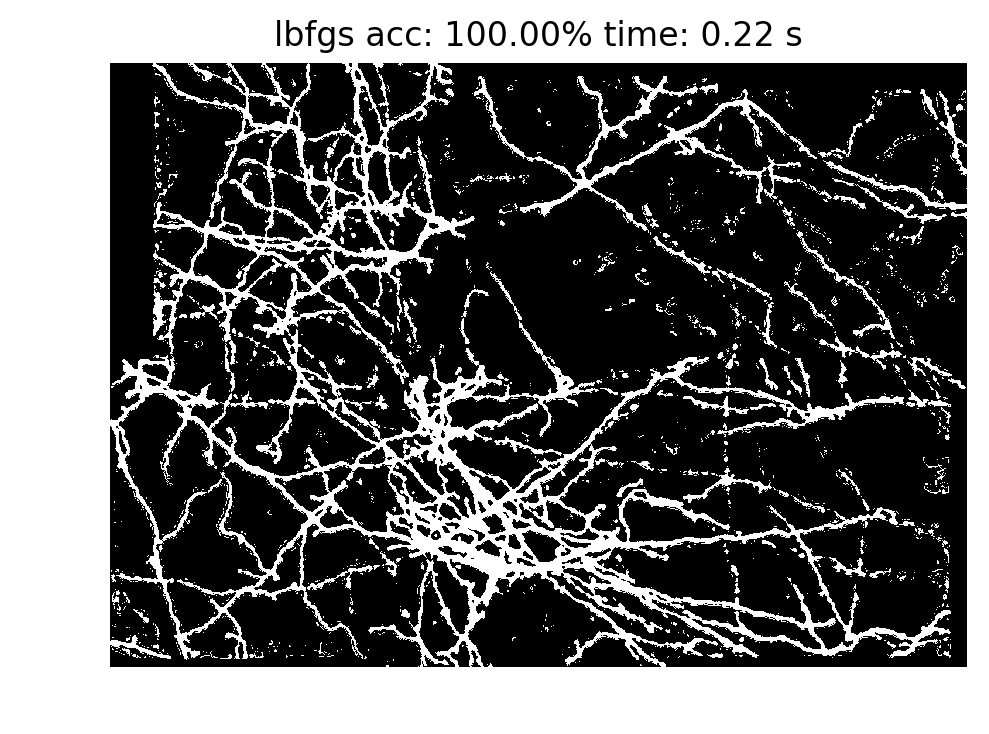

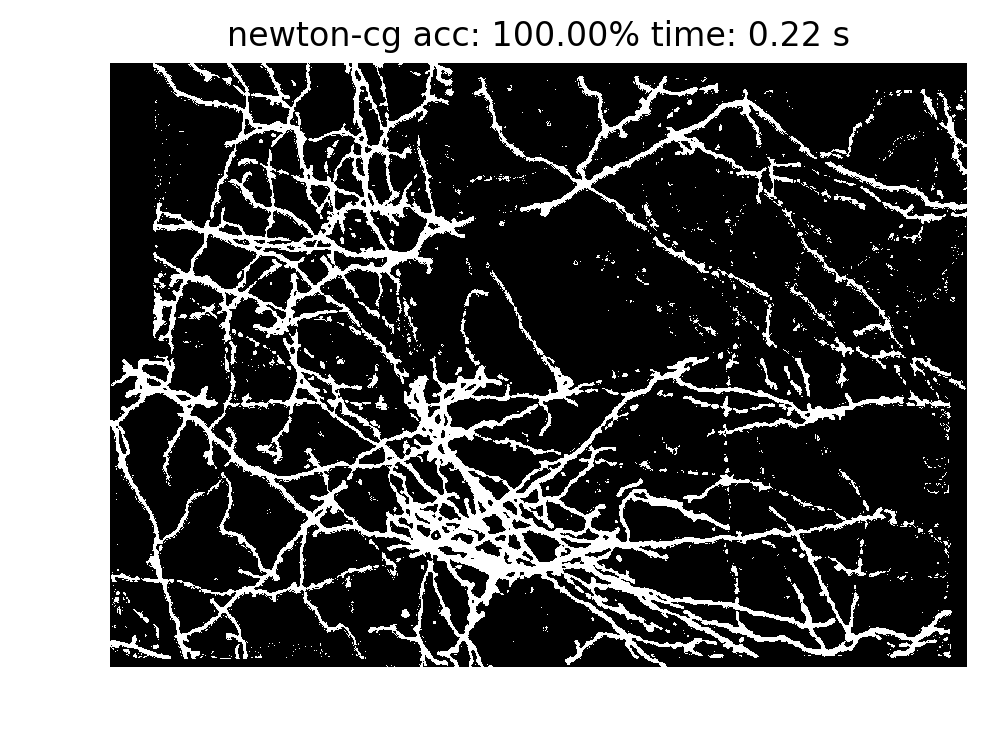

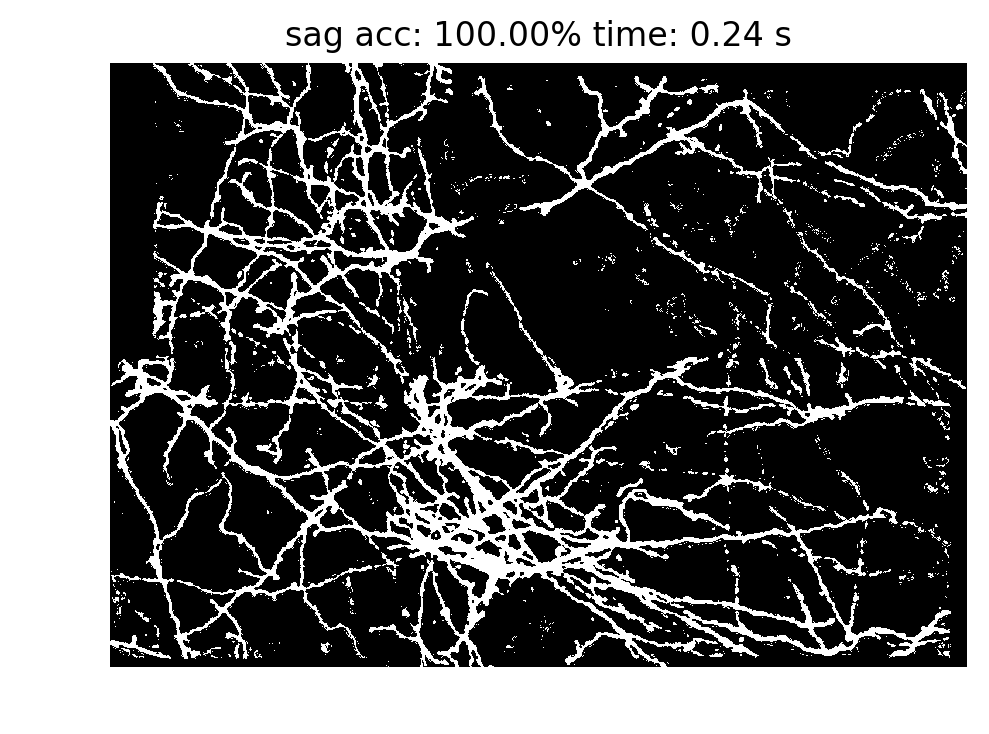

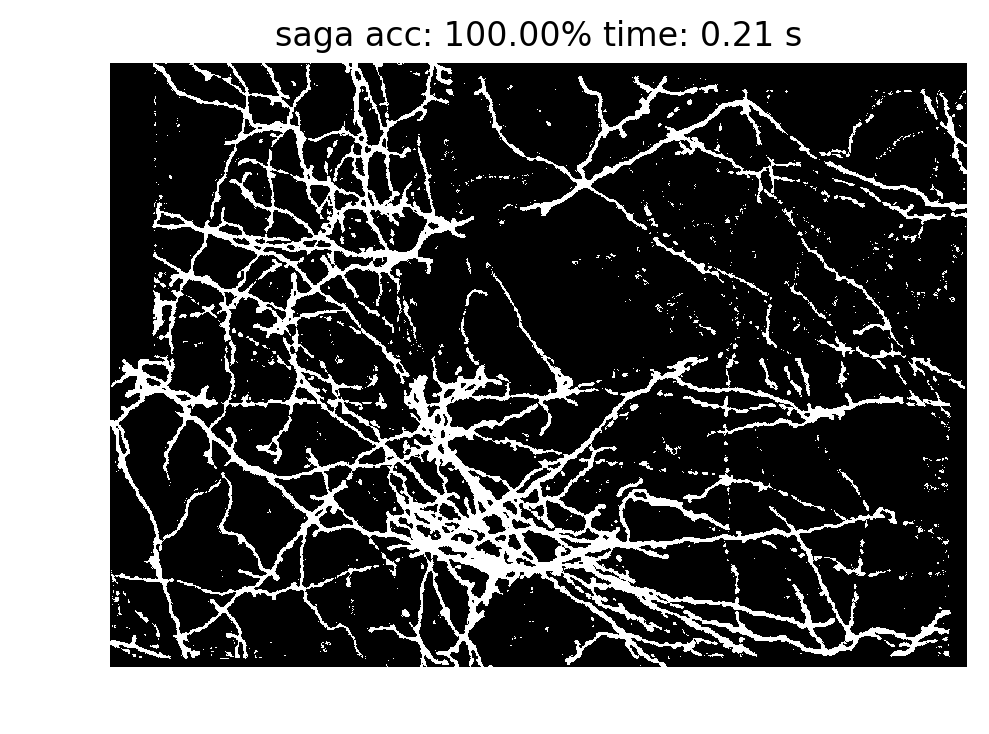

In [12]:
top_filters = sorted_indices[:10]
reduced_train_x = train_x[:, top_filters]

for solver in ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga']:
    start = time.time()
    rf_reduced = ensemble.RandomForestClassifier(n_estimators=10,
                                     criterion='gini',
                                     max_depth=None,
                                     min_samples_split=2,
                                     min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0,
                                     max_features='auto',
                                     max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     bootstrap=True,
                                     oob_score=True,
                                     n_jobs=-1,
                                     random_state=None,
                                     verbose=0,
                                     warm_start=False,
                                     class_weight=None)

    rf_reduced.fit(reduced_train_x, train_y)
    end = time.time()
    acc = rf_reduced.score(reduced_train_x, train_y)
    show_classifier_result(compiled_data[:, :, top_filters], rf_reduced)
    plt.gca().set_title('{} acc: {:.2%} time: {:.2f} s'.format(solver, acc, end-start))

In [14]:
# TESTING
x = []
y = []

for i in range(1,100,2):
    rf = ensemble.RandomForestClassifier(n_estimators=i,
                                         criterion='gini',
                                         max_depth=None,
                                         min_samples_split=2,
                                         min_samples_leaf=1,
                                         min_weight_fraction_leaf=0.0,
                                         max_features='auto',
                                         max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         bootstrap=True,
                                         oob_score=True,
                                         n_jobs=-1,
                                         random_state=None,
                                         verbose=0,
                                         warm_start=False,
                                         class_weight=None)


    rf.fit(train_x, train_y)
    rf.score(train_x, train_y)
    #print("Score: ", rf.oob_score_)
    #print("Feature Importance: ", rf.feature_importances_)
    #show_classifier_result(compiled_data, rf)

    x.append(i)
    y.append(rf.oob_score_)
    

/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/media/orpheus92/OS/conda/envs/Ditorch/lib/

# oob_score vs n_estimator

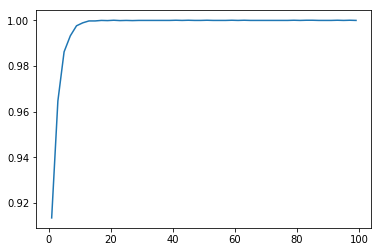

In [15]:
plt.plot(x,y)

n_estimators, max_depth, min_samples_split, min_samples_leaf

In [16]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


print(__doc__)

RANDOM_STATE = 123


# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, oob_score=True,
                               n_jobs=-1,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features='log2',
                               oob_score=True,
                               n_jobs=-1,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(n_estimators=100,
                               warm_start=True, max_features=None,
                               oob_score=True,
                               n_jobs=-1,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(train_x, train_y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))


Automatically created module for IPython interactive environment


/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/media/orpheus92/OS/conda/envs/Ditorch/lib/

/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/media/orpheus92/OS/conda/envs/Ditorch/lib/

# Generate the "OOB error rate" vs. "n_estimators" plot.


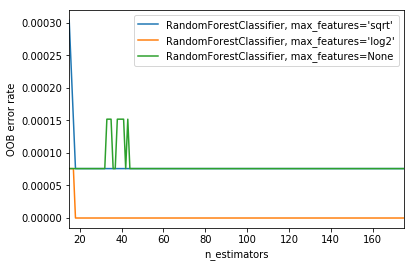

In [17]:
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=2, random_state=0)
#paramters to be compared 
tuned_parameters = [{'min_samples_leaf':[1,2,3,4,5], 'n_estimators':[10, 20, 50, 80, 100, 150], 'max_features':['log2','sqrt',None], 'min_samples_split':[2,3,4]}]

#Cross Validation to choose best paramters 

clf = GridSearchCV(estimator=rfc,param_grid=tuned_parameters, cv=5, n_jobs=1)

clf.fit(train_x, train_y)


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'min_samples_leaf': [1, 2, 3, 4, 5], 'n_estimators': [10, 20, 50, 80, 100, 150], 'max_features': ['log2', 'sqrt', None], 'min_samples_split': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [57]:
print('Best parameters:')

print(clf.best_params_)

Best parameters:
{'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10}


In [58]:
X, y = train_x, train_y

In [59]:
# Default parameters 
rf0 = RandomForestClassifier(oob_score=True, random_state=10)
rf0.fit(X,y)
print(rf0.oob_score_)
y_predprob = rf0.predict_proba(X)[:,1]
print("AUC Score (Train): %f" % metrics.roc_auc_score(y,y_predprob))
# oob_score 0.99818，AUC score: 1.00
#（AUC是指从一堆样本中随机抽一个，抽到正样本的概率比抽到负样本的概率 大的可能性）。相对于GBDT的默认参数输出，RF的默认参数拟合效果对本例要好一些。
 

    

0.9981778148963633
AUC Score (Train): 1.000000


/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [67]:
rf0 = RandomForestClassifier(oob_score=True, random_state=10, min_samples_leaf=5, min_samples_split=2, n_estimators=10)
rf0.fit(X,y)
print(rf0.oob_score_)
y_predprob = rf0.predict_proba(X)[:,1]
print("AUC Score (Train): %f" % metrics.roc_auc_score(y,y_predprob))

0.9980259661377269
AUC Score (Train): 1.000000


/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
#Tesing different # of esitmators
param_test1= {'n_estimators':range(10,71,10)}
gsearch1= GridSearchCV(estimator = RandomForestClassifier(min_samples_split=100,
                                 min_samples_leaf=20,max_depth=8,max_features='sqrt' ,random_state=10),
                       param_grid =param_test1, scoring='roc_auc',cv=5)
gsearch1.fit(X,y)
gsearch1.grid_scores_,gsearch1.best_params_, gsearch1.best_score_
# Results: 



/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.99538, std: 0.00844, params: {'n_estimators': 10},
  mean: 0.99552, std: 0.00850, params: {'n_estimators': 20},
  mean: 0.99553, std: 0.00853, params: {'n_estimators': 30},
  mean: 0.99555, std: 0.00853, params: {'n_estimators': 40},
  mean: 0.99554, std: 0.00853, params: {'n_estimators': 50},
  mean: 0.99553, std: 0.00854, params: {'n_estimators': 60},
  mean: 0.99552, std: 0.00855, params: {'n_estimators': 70}],
 {'n_estimators': 40},
 0.9955452261227383)

In [69]:
 
# Using the best paramters so far to test the best paramters for max_depth and min_samples_split: 
param_test2= {'max_depth':range(3,14,2), 'min_samples_split':range(50,201,20)}
gsearch2= GridSearchCV(estimator = RandomForestClassifier(n_estimators= 40,
                                 min_samples_leaf=20,max_features='sqrt' ,oob_score=True,random_state=10),
   param_grid = param_test2,scoring='roc_auc',iid=False, cv=5)
gsearch2.fit(X,y)
gsearch2.grid_scores_,gsearch2.best_params_, gsearch2.best_score_
#Results: 

 

/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.99555, std: 0.00854, params: {'max_depth': 3, 'min_samples_split': 50},
  mean: 0.99553, std: 0.00853, params: {'max_depth': 3, 'min_samples_split': 70},
  mean: 0.99554, std: 0.00854, params: {'max_depth': 3, 'min_samples_split': 90},
  mean: 0.99554, std: 0.00854, params: {'max_depth': 3, 'min_samples_split': 110},
  mean: 0.99553, std: 0.00853, params: {'max_depth': 3, 'min_samples_split': 130},
  mean: 0.99553, std: 0.00853, params: {'max_depth': 3, 'min_samples_split': 150},
  mean: 0.99553, std: 0.00853, params: {'max_depth': 3, 'min_samples_split': 170},
  mean: 0.99553, std: 0.00853, params: {'max_depth': 3, 'min_samples_split': 190},
  mean: 0.99554, std: 0.00853, params: {'max_depth': 5, 'min_samples_split': 50},
  mean: 0.99553, std: 0.00853, params: {'max_depth': 5, 'min_samples_split': 70},
  mean: 0.99554, std: 0.00853, params: {'max_depth': 5, 'min_samples_split': 90},
  mean: 0.99555, std: 0.00854, params: {'max_depth': 5, 'min_samples_split': 110},
  mean: 0.

In [71]:
# score with the best paramters so far 
rf1= RandomForestClassifier(n_estimators= 40, max_depth=5, min_samples_split=110,
                                 min_samples_leaf=20,max_features='sqrt' ,oob_score=True,random_state=10)
rf1.fit(X,y)
print (rf1.oob_score_)
 


0.9955963859995445


In [72]:
# Tuning parameters for min_samples_split and min_samples_leaf at the same time: 

param_test3= {'min_samples_split':range(80,150,20), 'min_samples_leaf':range(10,60,10)}
gsearch3= GridSearchCV(estimator = RandomForestClassifier(n_estimators= 40,max_depth=5,
                                 max_features='sqrt' ,oob_score=True, random_state=10),
   param_grid = param_test3,scoring='roc_auc',iid=False, cv=5)
gsearch3.fit(X,y)
gsearch3.grid_scores_,gsearch3.best_params_, gsearch3.best_score_


 

/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.99481, std: 0.01006, params: {'min_samples_leaf': 10, 'min_samples_split': 80},
  mean: 0.99482, std: 0.01007, params: {'min_samples_leaf': 10, 'min_samples_split': 100},
  mean: 0.99479, std: 0.01005, params: {'min_samples_leaf': 10, 'min_samples_split': 120},
  mean: 0.99479, std: 0.01006, params: {'min_samples_leaf': 10, 'min_samples_split': 140},
  mean: 0.99554, std: 0.00853, params: {'min_samples_leaf': 20, 'min_samples_split': 80},
  mean: 0.99555, std: 0.00854, params: {'min_samples_leaf': 20, 'min_samples_split': 100},
  mean: 0.99553, std: 0.00853, params: {'min_samples_leaf': 20, 'min_samples_split': 120},
  mean: 0.99553, std: 0.00853, params: {'min_samples_leaf': 20, 'min_samples_split': 140},
  mean: 0.99554, std: 0.00854, params: {'min_samples_leaf': 30, 'min_samples_split': 80},
  mean: 0.99555, std: 0.00854, params: {'min_samples_leaf': 30, 'min_samples_split': 100},
  mean: 0.99553, std: 0.00854, params: {'min_samples_leaf': 30, 'min_samples_split': 120},
  

In [73]:

#Tunnig max features: 
param_test4= {'max_features':['sqrt', 'log2', None]}
gsearch4= GridSearchCV(estimator = RandomForestClassifier(n_estimators= 40,max_depth=5, min_samples_split=80,
                                 min_samples_leaf=50 ,oob_score=True, random_state=10),
   param_grid = param_test4,scoring='roc_auc',iid=False, cv=5)
gsearch4.fit(X,y)
gsearch4.grid_scores_,gsearch4.best_params_, gsearch4.best_score_
#输出如下：


/media/orpheus92/OS/conda/envs/Ditorch/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.99745, std: 0.00473, params: {'max_features': 'sqrt'},
  mean: 0.99703, std: 0.00552, params: {'max_features': 'log2'},
  mean: 0.99691, std: 0.00568, params: {'max_features': None}],
 {'max_features': 'sqrt'},
 0.9974466626273246)

In [80]:

 
#Use all the best parameters to train the model 
rf2= RandomForestClassifier(n_estimators= 40, max_depth=5, min_samples_split=80,
                                 min_samples_leaf=50, max_features='sqrt' ,oob_score=True, random_state=10)
rf2.fit(X,y)
print(rf2.oob_score_)



0.9959760078961355


## Dan (Adaboost)

In [ ]:
ada = ensemble.AdaBoostClassifier(base_estimator=None,
                                  n_estimators=50,
                                  learning_rate=1.0,
                                  algorithm='SAMME.R',
                                  random_state=None)
ada.fit(train_x, train_y)
ada.score(train_x, train_y)
show_classifier_result(compiled_data, ada)

## TODO

Other Models to try:

* Linear SVM
* Polynomial SVM
* Multilayer Perceptron
* Linear Discriminant Analysis
* Linear Classifiers